In [1]:
import os
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scprep
import numpy as np
from pyplink import PyPlink
import tqdm

os.chdir('../../src')
import mappings
import data_loader

In [3]:
# Load HGDP
exp_path = '/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP'
fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnet'
data_path = os.path.join(exp_path, fname)

pedfile = PyPlink(data_path)

In [ ]:
#Degree normalization instead of adaptive kernel. Maybe keep effect of density instead of removing it.

In [4]:
all_samples = pedfile.get_fam()
all_samples.head()

,fid,iid,father,mother,gender,status
0,CHMI_CHMI3_WGS2,CHMI_CHMI3_WGS2,0,0,0,-9
1,HG00096,HG00096,0,0,0,-9
2,HG00097,HG00097,0,0,0,-9
3,HG00099,HG00099,0,0,0,-9
4,HG00100,HG00100,0,0,0,-9


In [5]:
all_markers = pedfile.get_bim()
all_markers.head()

,chrom,pos,cm,a1,a2
snp,,,,,
1:858952:G:A,1,858952,0,A,G
1:905373:T:C,1,905373,0,C,T
1:911428:C:T,1,911428,0,T,C
1:918870:A:G,1,918870,0,G,A
1:931513:T:C,1,931513,0,C,T


In [6]:
try:
    genotypes_array = np.load(exp_path + '_raw_genotypes.npy')
except:
    genotypes_array = np.zeros([pedfile.get_nb_samples(), pedfile.get_nb_markers()], dtype=np.int8)

    for i, (marker_id, genotypes) in tqdm.tqdm(enumerate(pedfile)):
        genotypes_array[:,i] = genotypes

    np.save(exp_path + '_raw_genotypes.npy', genotypes_array)

228396it [00:06, 35569.02it/s]


In [8]:
genotypes_array.shape

(4151, 228396)

In [9]:
labels = pd.read_csv('/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.reduced.tsv', sep='\t')
labels = labels[1:] # remove first row

In [23]:
def make_palette_label_order_HGDP(populations, superpopulations):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(mappings.pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = mappings.pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(mappings.label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(superpopulations):
        for pop in np.unique(populations[superpopulations==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(mappings.pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(superpopulations):
        for pop in np.unique(populations[superpopulations==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(labels['Population'],
                                                                                                                               labels['Genetic_region'])

In [32]:
from sklearn.decomposition import PCA

# Fit PCA model
pca_obj = PCA(n_components=100)  # Number of components to keep
pca_obj.fit(genotypes_array[1:,:])
pca_input = pca_obj.transform(genotypes_array[1:,:])

In [39]:
import phate

phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform(pca_input)

Running PHATE on 4150 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.96 seconds.
  Calculating affinities...
  Calculated affinities in 0.24 seconds.
Calculated graph and diffusion operator in 1.21 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.23 seconds.
  Calculating KMeans...
  Calculated KMeans in 4.76 seconds.
Calculated landmark operator in 5.75 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.00 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.19 seconds.


Text(0.5, 1.0, 'PHATE of HGDP')

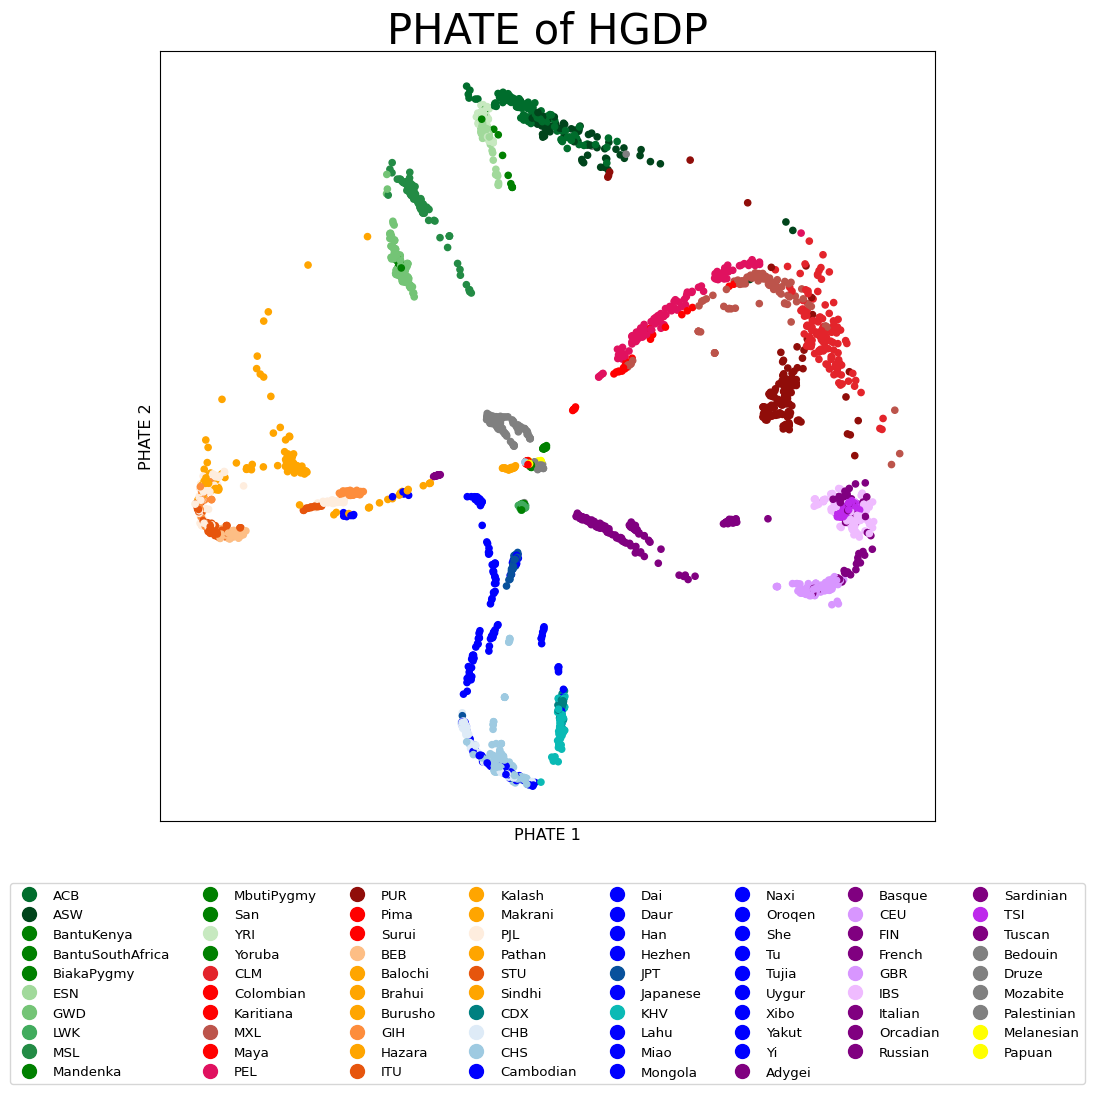

In [41]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(phate_emb, 
                      s=20, 
                      cmap=pop_palette_hgdp_fine, ax=ax,
                      c=labels['Population'], 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

ax.set_title("PHATE of HGDP", fontsize=30)

In [44]:
pd.DataFrame({'id': all_samples['fid'][1:], 'PHATE1': phate_emb[:,0], 'PHATE2': phate_emb[:,1]}).to_csv(os.path.join(exp_path, fname) + 'PHATE_emb.csv')
print(os.path.join(exp_path, fname) + 'PHATE_emb.csv')

/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnetPHATE_emb.csv
